In [1]:
import numpy as np
import pickle
import os
import tarfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import wandb

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms


In [ ]:
# Extract cifar-100-python.tar.gz to separate data
with tarfile.open("cifar-100-python.tar.gz", 'r|gz') as f:
        f.extractall(path="./")
        f.close()

In [69]:
data = pickle.load(open(os.path.join("cifar-100-python", "train"), 'rb'), encoding='latin1')
X_train_np = data['data']
y_train_np = np.asarray(data['fine_labels'], np.int8)

data = pickle.load(open(os.path.join('cifar-100-python', 'test'), 'rb'), encoding='latin1')
X_test_np = data['data']
y_test_np = np.asarray(data['fine_labels'], np.int8)

In [70]:
# reshape
X_train_np = X_train_np.reshape(-1, 3, 32, 32)
X_test_np = X_test_np.reshape(-1, 3, 32, 32)


In [39]:
X_train_np.shape

(50000, 3, 32, 32)

D:\Git\NSIETE\Zadanie 2\.env_zadanie2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

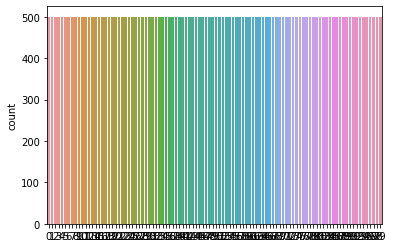

In [40]:
sns.countplot(y_train_np)

TypeError: Invalid shape (3, 32, 32) for image data

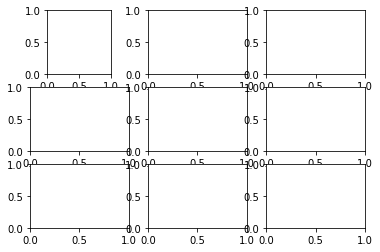

In [28]:
x_max,y_max = 3,3
offset = 0

f, axarr = plt.subplots(y_max,x_max)
for y in range(y_max):
    for x in range(x_max):
        axarr[y,x].imshow(X_train_np[y*y_max+x+offset])
# print(y_train[i])
# plt.imshow(np.rollaxis(X_train[i], 0, 3))

In [41]:
mean = X_train_np.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
std = X_train_np.std(axis=(0,1,2), keepdims=True).astype(np.float32)

X_train_np = (X_train_np - mean) / std
X_test_np = (X_test_np - mean) / std

In [46]:
def train_test_split_v2(X_train,y_train,test_size,random_state=None,sample_limit=None):
    total_count = len(X_train)
    if sample_limit:
        _, X_train, _, y_train = train_test_split(X_train, y_train, test_size=1/(total_count/sample_limit), random_state=random_state)
    return train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

In [56]:
X_train,X_valid,y_train,y_valid= train_test_split_v2(X_train_np, y_train_np,sample_limit=None, test_size=1/6, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_train.shape[0]+X_valid.shape[0])


In [77]:
class CIFAR(Dataset):
    def __init__(self, X,y,transform=None):
        self.X=X
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        image = self.X[index]
        label = self.y[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [78]:
train_data = CIFAR(X_train,y_train, transform=transforms.ToTensor())
valid_data = CIFAR(X_valid,y_valid, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data,batch_size=256)
valid_loader = DataLoader(dataset=valid_data,batch_size=256)

In [79]:
dataiter=iter(train_loader)
images, labels = dataiter.next()
images = images.permute(0,2,1,3)
print('images shape: ', images.size())
print('labels shape: ', labels.size())

images shape:  torch.Size([256, 3, 32, 32])
labels shape:  torch.Size([256])


In [72]:
class SimpleNet(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(8192,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class Net(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [73]:
model = SimpleNet(3,100)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [80]:
output = model.forward(images)


In [81]:
output.shape

torch.Size([256, 100])